mutual information

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import os


In [2]:
hyperparams = {
    'num_generators': 10,      # Number of generators
    'latent_dim': 100,        # Dimension of the latent space (input noise)
    'num_epochs': 50,         # Number of training epochs
    'batch_size': 64,         # Batch size
    'learning_rate': 0.0002,  # Learning rate for optimizers
    'image_size': 28,         # MNIST image size
    'num_classes': 10,        # Number of classes in MNIST
    'beta1': 0.5,             # Beta1 hyperparameter for Adam optimizer
    'mi_loss_weight': 0.1,    # Weight for mutual information loss
    'save_images': False,      # Whether to save generated images
    'output_dir': 'images',   # Directory to save images
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}


In [3]:
def get_data_loader(batch_size, image_size):
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ])
    dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader


In [4]:
class Generator(nn.Module):
    def __init__(self, latent_dim, image_size):
        super(Generator, self).__init__()
        self.image_size = image_size
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(True),
            nn.Linear(1024, image_size * image_size),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(z.size(0), 1, self.image_size, self.image_size)
        return img

class Discriminator(nn.Module):
    def __init__(self, image_size):
        super(Discriminator, self).__init__()
        self.image_size = image_size
        self.model = nn.Sequential(
            nn.Linear(image_size * image_size, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

class Classifier(nn.Module):
    def __init__(self, image_size, num_classes):
        super(Classifier, self).__init__()
        self.image_size = image_size
        self.model = nn.Sequential(
            nn.Linear(image_size * image_size, 512),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        class_probs = self.model(img_flat)
        return class_probs


In [5]:
def initialize_models(hyperparams):
    num_generators = hyperparams['num_generators']
    latent_dim = hyperparams['latent_dim']
    image_size = hyperparams['image_size']
    num_classes = hyperparams['num_classes']
    device = hyperparams['device']
    
    generators = [Generator(latent_dim, image_size).to(device) for _ in range(num_generators)]
    discriminator = Discriminator(image_size).to(device)
    classifier = Classifier(image_size, num_classes).to(device)
    
    return generators, discriminator, classifier


In [6]:
def initialize_optimizers(generators, discriminator, classifier, hyperparams):
    learning_rate = hyperparams['learning_rate']
    beta1 = hyperparams['beta1']
    
    optimizer_G = [optim.Adam(g.parameters(), lr=learning_rate, betas=(beta1, 0.999)) for g in generators]
    optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta1, 0.999))
    optimizer_C = optim.Adam(classifier.parameters(), lr=learning_rate, betas=(beta1, 0.999))
    
    return optimizer_G, optimizer_D, optimizer_C


In [7]:
def mutual_information_loss(gen_imgs1, gen_imgs2, classifier):
    # Compute the outputs
    probs1 = classifier(gen_imgs1)
    probs2 = classifier(gen_imgs2)
    # Compute joint distribution approximation
    joint_probs = probs1.unsqueeze(2) * probs2.unsqueeze(1)
    joint_probs = joint_probs.mean(dim=0)  # Average over batch
    # Compute marginal distributions
    marg_probs1 = probs1.mean(dim=0)
    marg_probs2 = probs2.mean(dim=0)
    # Compute mutual information
    mi_matrix = joint_probs * torch.log(joint_probs / (marg_probs1.unsqueeze(1) * marg_probs2.unsqueeze(0) + 1e-8) + 1e-8)
    mi = mi_matrix.sum()
    return mi


In [8]:
def generate_images(epoch, generators, hyperparams):
    device = hyperparams['device']
    latent_dim = hyperparams['latent_dim']
    num_generators = hyperparams['num_generators']
    image_size = hyperparams['image_size']
    
    with torch.no_grad():
        # Generate images
        z = torch.randn(num_generators * 10, latent_dim, device=device)
        gen_imgs = []
        for idx, g in enumerate(generators):
            gen_img = g(z[idx*10:(idx+1)*10])
            gen_imgs.append(gen_img)
        gen_imgs = torch.cat(gen_imgs, dim=0)
        gen_imgs = gen_imgs * 0.5 + 0.5  # Rescale images to [0, 1]
        grid = vutils.make_grid(gen_imgs.cpu(), nrow=10)
        plt.figure(figsize=(10,10))
        plt.imshow(np.transpose(grid, (1,2,0)))
        plt.axis('off')
        plt.title(f'Epoch {epoch}')
        plt.show()
        # Save the figure if needed
        if hyperparams['save_images']:
            os.makedirs(hyperparams['output_dir'], exist_ok=True)
            plt.savefig(f"{hyperparams['output_dir']}/epoch_{epoch}.png")
            plt.close()


In [9]:
def train(hyperparams):
    # Unpack hyperparameters
    num_epochs = hyperparams['num_epochs']
    batch_size = hyperparams['batch_size']
    latent_dim = hyperparams['latent_dim']
    num_generators = hyperparams['num_generators']
    mi_loss_weight = hyperparams['mi_loss_weight']
    device = hyperparams['device']
    
    # Get data loader
    dataloader = get_data_loader(batch_size, hyperparams['image_size'])
    
    # Initialize models and optimizers
    generators, discriminator, classifier = initialize_models(hyperparams)
    optimizer_G, optimizer_D, optimizer_C = initialize_optimizers(generators, discriminator, classifier, hyperparams)
    
    # Loss functions
    adversarial_loss = nn.BCELoss()
    classification_loss = nn.CrossEntropyLoss()
    
    # Lists to store loss values for plotting
    d_losses = []
    g_losses = []
    c_losses = []
    epochs_list = []
    
    # Training loop
    for epoch in range(num_epochs):
        for i, (imgs, labels) in enumerate(dataloader):
            # Configure inputs
            real_imgs = imgs.to(device)
            labels = labels.to(device)
            batch_size_curr = real_imgs.size(0)
            
            # Adversarial ground truths
            valid = torch.ones(batch_size_curr, 1, device=device)
            fake = torch.zeros(batch_size_curr, 1, device=device)
            
            # ---------------------
            #  Train Discriminator
            # ---------------------
            optimizer_D.zero_grad()
            # Real images
            real_validity = discriminator(real_imgs)
            d_real_loss = adversarial_loss(real_validity, valid)
            # Fake images from all generators
            fake_imgs = []
            for g in generators:
                z = torch.randn(batch_size_curr, latent_dim, device=device)
                gen_imgs = g(z)
                fake_imgs.append(gen_imgs)
            fake_imgs_all = torch.cat(fake_imgs, dim=0)
            fake_validity = discriminator(fake_imgs_all.detach())
            d_fake_loss = adversarial_loss(fake_validity, fake.repeat(num_generators, 1))
            # Total discriminator loss
            d_loss = (d_real_loss + d_fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()
            
            # ---------------------
            #  Train Classifier
            # ---------------------
            optimizer_C.zero_grad()
            # Classifier loss on real images
            class_probs = classifier(real_imgs)
            c_loss = classification_loss(class_probs, labels)
            c_loss.backward()
            optimizer_C.step()
            
            # -----------------
            #  Train Generators
            # -----------------
            total_g_loss = 0  # To accumulate generator losses
            for idx, g in enumerate(generators):
                optimizer_G[idx].zero_grad()
                z = torch.randn(batch_size_curr, latent_dim, device=device)
                gen_imgs = g(z)
                # Adversarial loss
                validity = discriminator(gen_imgs)
                g_loss = adversarial_loss(validity, valid)
                # Mutual Information Loss
                mi_loss = 0
                for jdx, other_g in enumerate(generators):
                    if idx != jdx:
                        z_other = torch.randn(batch_size_curr, latent_dim, device=device)
                        gen_imgs_other = other_g(z_other).detach()
                        mi_loss += mutual_information_loss(gen_imgs, gen_imgs_other, classifier)
                # Total generator loss
                total_loss = g_loss + mi_loss_weight * mi_loss
                total_loss.backward()
                optimizer_G[idx].step()
                total_g_loss += total_loss.item()
            
            # --------------
            # Log Progress
            # --------------
            if i % 100 == 0:
                avg_g_loss = total_g_loss / num_generators
                print(f"[Epoch {epoch+1}/{num_epochs}] [Batch {i}/{len(dataloader)}] "
                      f"[D loss: {d_loss.item():.4f}] [G loss: {avg_g_loss:.4f}] [C loss: {c_loss.item():.4f}]")
        
        # Store loss values for plotting
        d_losses.append(d_loss.item())
        g_losses.append(avg_g_loss)
        c_losses.append(c_loss.item())
        epochs_list.append(epoch+1)
        
        # Generate and save images every 5 epochs
        if (epoch + 1) % 5 == 0:
            generate_images(epoch+1, generators, hyperparams)
    
    # Plot the learning curves after training
    plt.figure(figsize=(10,5))
    plt.plot(epochs_list, d_losses, label='Discriminator Loss')
    plt.plot(epochs_list, g_losses, label='Generator Loss')
    plt.plot(epochs_list, c_losses, label='Classifier Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curves')
    plt.show()


[Epoch 1/50] [Batch 0/938] [D loss: 0.6822] [G loss: 0.6496] [C loss: 2.3011]
[Epoch 1/50] [Batch 100/938] [D loss: 0.6646] [G loss: 0.8525] [C loss: 1.8616]
[Epoch 1/50] [Batch 200/938] [D loss: 0.6481] [G loss: 0.8440] [C loss: 1.7306]
[Epoch 1/50] [Batch 300/938] [D loss: 0.6525] [G loss: 0.8204] [C loss: 1.6658]
[Epoch 1/50] [Batch 400/938] [D loss: 0.6475] [G loss: 0.6982] [C loss: 1.6514]
[Epoch 1/50] [Batch 500/938] [D loss: 0.6425] [G loss: 0.8916] [C loss: 1.6103]
[Epoch 1/50] [Batch 600/938] [D loss: 0.6389] [G loss: 0.7221] [C loss: 1.5804]
[Epoch 1/50] [Batch 700/938] [D loss: 0.6034] [G loss: 0.9255] [C loss: 1.5730]
[Epoch 1/50] [Batch 800/938] [D loss: 0.6287] [G loss: 0.9863] [C loss: 1.5765]
[Epoch 1/50] [Batch 900/938] [D loss: 0.6273] [G loss: 0.8504] [C loss: 1.5336]
[Epoch 2/50] [Batch 0/938] [D loss: 0.6929] [G loss: 0.6481] [C loss: 1.5970]
[Epoch 2/50] [Batch 100/938] [D loss: 0.6148] [G loss: 1.2000] [C loss: 1.5571]
[Epoch 2/50] [Batch 200/938] [D loss: 0.7473

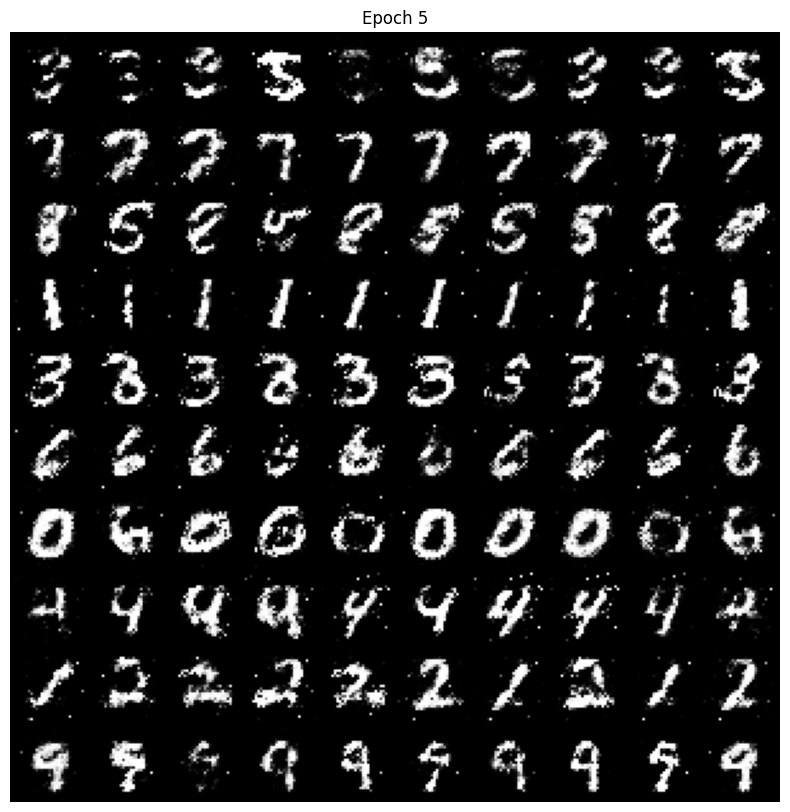

[Epoch 6/50] [Batch 0/938] [D loss: 0.6909] [G loss: 0.7046] [C loss: 1.4939]
[Epoch 6/50] [Batch 100/938] [D loss: 0.6893] [G loss: 0.6948] [C loss: 1.5818]
[Epoch 6/50] [Batch 200/938] [D loss: 0.6885] [G loss: 0.7153] [C loss: 1.5149]
[Epoch 6/50] [Batch 300/938] [D loss: 0.6991] [G loss: 0.7204] [C loss: 1.5249]
[Epoch 6/50] [Batch 400/938] [D loss: 0.6947] [G loss: 0.7006] [C loss: 1.5138]
[Epoch 6/50] [Batch 500/938] [D loss: 0.6929] [G loss: 0.7233] [C loss: 1.5093]
[Epoch 6/50] [Batch 600/938] [D loss: 0.6902] [G loss: 0.7239] [C loss: 1.5344]
[Epoch 6/50] [Batch 700/938] [D loss: 0.6874] [G loss: 0.7020] [C loss: 1.5631]
[Epoch 6/50] [Batch 800/938] [D loss: 0.6924] [G loss: 0.7013] [C loss: 1.4842]
[Epoch 6/50] [Batch 900/938] [D loss: 0.6983] [G loss: 0.6986] [C loss: 1.5413]
[Epoch 7/50] [Batch 0/938] [D loss: 0.6841] [G loss: 0.7082] [C loss: 1.4965]
[Epoch 7/50] [Batch 100/938] [D loss: 0.6847] [G loss: 0.7282] [C loss: 1.5483]
[Epoch 7/50] [Batch 200/938] [D loss: 0.6835

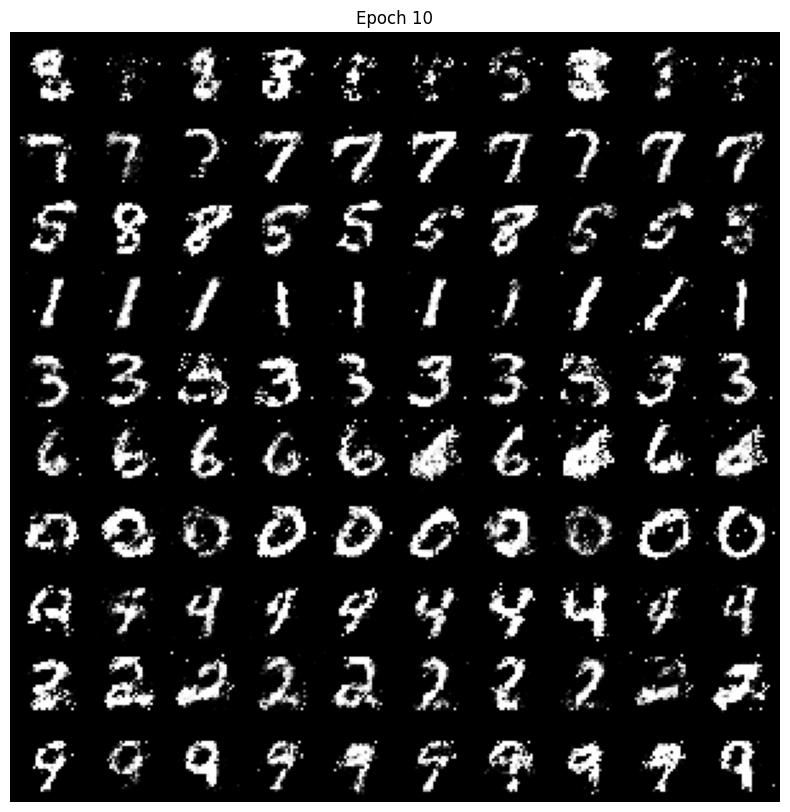

[Epoch 11/50] [Batch 0/938] [D loss: 0.6941] [G loss: 0.7014] [C loss: 1.5022]
[Epoch 11/50] [Batch 100/938] [D loss: 0.6924] [G loss: 0.7124] [C loss: 1.5152]
[Epoch 11/50] [Batch 200/938] [D loss: 0.6942] [G loss: 0.6996] [C loss: 1.4956]
[Epoch 11/50] [Batch 300/938] [D loss: 0.7028] [G loss: 0.6780] [C loss: 1.4754]
[Epoch 11/50] [Batch 400/938] [D loss: 0.6866] [G loss: 0.7178] [C loss: 1.5190]
[Epoch 11/50] [Batch 500/938] [D loss: 0.6912] [G loss: 0.7071] [C loss: 1.4910]
[Epoch 11/50] [Batch 600/938] [D loss: 0.6923] [G loss: 0.6997] [C loss: 1.4653]
[Epoch 11/50] [Batch 700/938] [D loss: 0.6985] [G loss: 0.7059] [C loss: 1.5014]
[Epoch 11/50] [Batch 800/938] [D loss: 0.6948] [G loss: 0.7225] [C loss: 1.4878]
[Epoch 11/50] [Batch 900/938] [D loss: 0.6947] [G loss: 0.7120] [C loss: 1.4861]
[Epoch 12/50] [Batch 0/938] [D loss: 0.6934] [G loss: 0.7179] [C loss: 1.5221]
[Epoch 12/50] [Batch 100/938] [D loss: 0.6903] [G loss: 0.7096] [C loss: 1.4639]
[Epoch 12/50] [Batch 200/938] [D

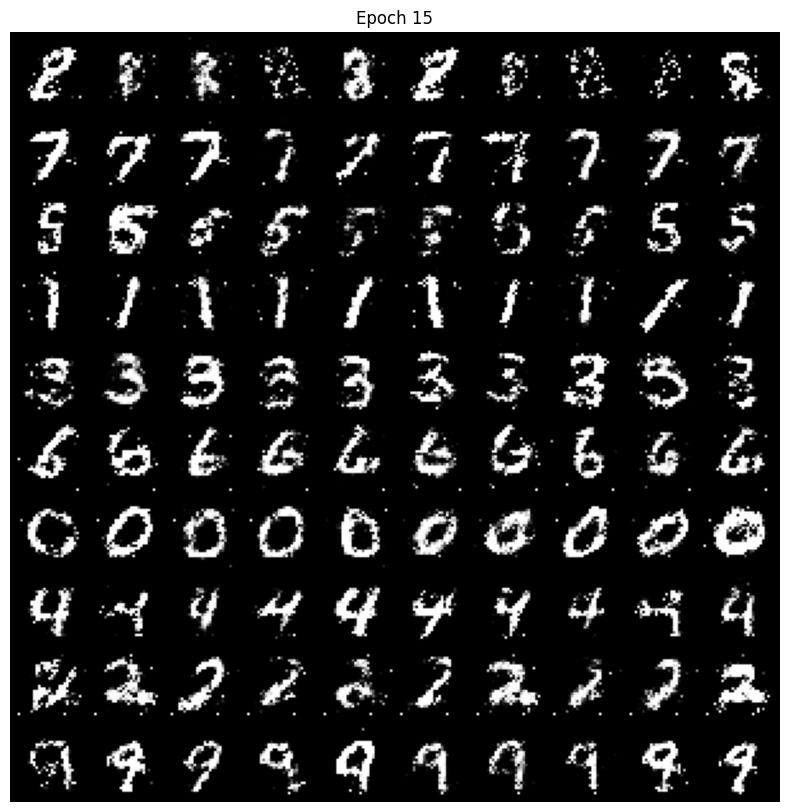

[Epoch 16/50] [Batch 0/938] [D loss: 0.6993] [G loss: 0.6789] [C loss: 1.4930]
[Epoch 16/50] [Batch 100/938] [D loss: 0.6929] [G loss: 0.6926] [C loss: 1.4777]
[Epoch 16/50] [Batch 200/938] [D loss: 0.6919] [G loss: 0.7052] [C loss: 1.4918]
[Epoch 16/50] [Batch 300/938] [D loss: 0.6917] [G loss: 0.7087] [C loss: 1.4887]
[Epoch 16/50] [Batch 400/938] [D loss: 0.6816] [G loss: 0.7081] [C loss: 1.5009]
[Epoch 16/50] [Batch 500/938] [D loss: 0.6967] [G loss: 0.7023] [C loss: 1.5094]
[Epoch 16/50] [Batch 600/938] [D loss: 0.6922] [G loss: 0.7210] [C loss: 1.5353]
[Epoch 16/50] [Batch 700/938] [D loss: 0.6995] [G loss: 0.7167] [C loss: 1.4713]
[Epoch 16/50] [Batch 800/938] [D loss: 0.7018] [G loss: 0.7027] [C loss: 1.5095]
[Epoch 16/50] [Batch 900/938] [D loss: 0.6928] [G loss: 0.6987] [C loss: 1.5257]
[Epoch 17/50] [Batch 0/938] [D loss: 0.6964] [G loss: 0.7143] [C loss: 1.5568]
[Epoch 17/50] [Batch 100/938] [D loss: 0.6906] [G loss: 0.7075] [C loss: 1.4612]
[Epoch 17/50] [Batch 200/938] [D

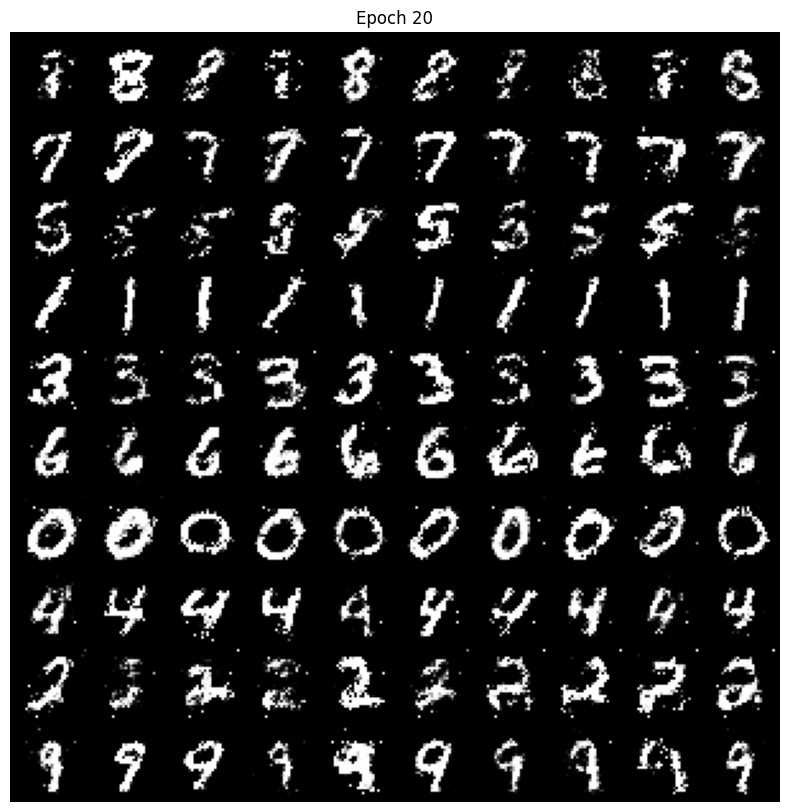

[Epoch 21/50] [Batch 0/938] [D loss: 0.6959] [G loss: 0.6793] [C loss: 1.4799]
[Epoch 21/50] [Batch 100/938] [D loss: 0.6931] [G loss: 0.6996] [C loss: 1.5095]
[Epoch 21/50] [Batch 200/938] [D loss: 0.6918] [G loss: 0.7060] [C loss: 1.5221]
[Epoch 21/50] [Batch 300/938] [D loss: 0.6944] [G loss: 0.6790] [C loss: 1.4911]
[Epoch 21/50] [Batch 400/938] [D loss: 0.6935] [G loss: 0.6909] [C loss: 1.4683]
[Epoch 21/50] [Batch 500/938] [D loss: 0.6901] [G loss: 0.6939] [C loss: 1.4627]
[Epoch 21/50] [Batch 600/938] [D loss: 0.6889] [G loss: 0.7043] [C loss: 1.5092]
[Epoch 21/50] [Batch 700/938] [D loss: 0.6965] [G loss: 0.7025] [C loss: 1.5103]
[Epoch 21/50] [Batch 800/938] [D loss: 0.6984] [G loss: 0.6951] [C loss: 1.4624]
[Epoch 21/50] [Batch 900/938] [D loss: 0.6887] [G loss: 0.7017] [C loss: 1.4782]
[Epoch 22/50] [Batch 0/938] [D loss: 0.6952] [G loss: 0.6969] [C loss: 1.4771]
[Epoch 22/50] [Batch 100/938] [D loss: 0.6942] [G loss: 0.7110] [C loss: 1.4908]
[Epoch 22/50] [Batch 200/938] [D

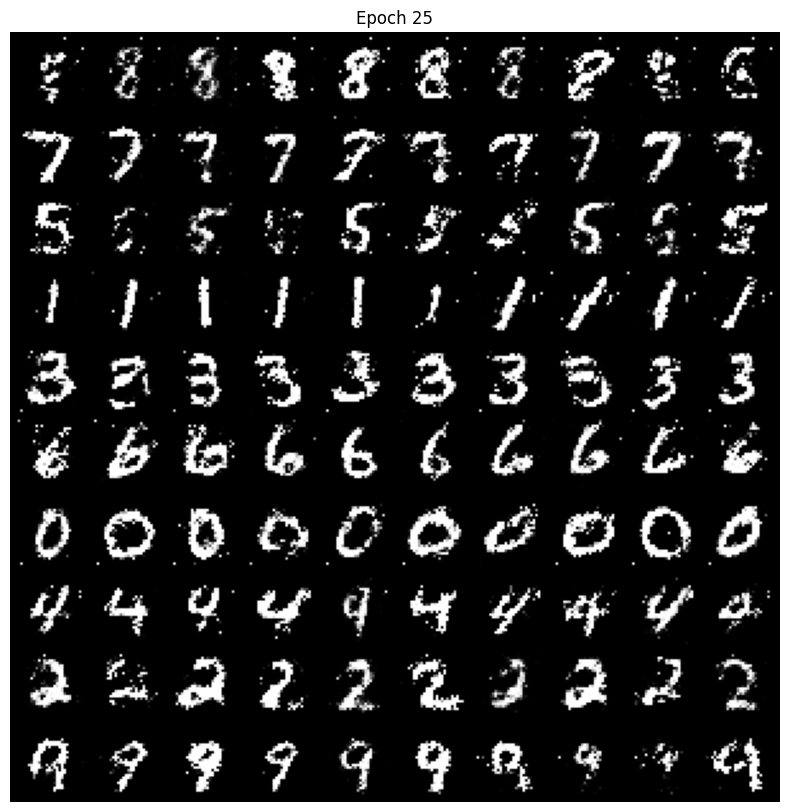

[Epoch 26/50] [Batch 0/938] [D loss: 0.6892] [G loss: 0.6901] [C loss: 1.4803]
[Epoch 26/50] [Batch 100/938] [D loss: 0.6898] [G loss: 0.7089] [C loss: 1.4616]
[Epoch 26/50] [Batch 200/938] [D loss: 0.6927] [G loss: 0.7041] [C loss: 1.5106]
[Epoch 26/50] [Batch 300/938] [D loss: 0.6930] [G loss: 0.7024] [C loss: 1.5181]
[Epoch 26/50] [Batch 400/938] [D loss: 0.6964] [G loss: 0.6909] [C loss: 1.4881]
[Epoch 26/50] [Batch 500/938] [D loss: 0.6947] [G loss: 0.6886] [C loss: 1.4762]
[Epoch 26/50] [Batch 600/938] [D loss: 0.6943] [G loss: 0.6900] [C loss: 1.4901]
[Epoch 26/50] [Batch 700/938] [D loss: 0.6925] [G loss: 0.6855] [C loss: 1.4639]
[Epoch 26/50] [Batch 800/938] [D loss: 0.6927] [G loss: 0.7064] [C loss: 1.4622]
[Epoch 26/50] [Batch 900/938] [D loss: 0.6930] [G loss: 0.6958] [C loss: 1.4752]
[Epoch 27/50] [Batch 0/938] [D loss: 0.6944] [G loss: 0.6919] [C loss: 1.4770]
[Epoch 27/50] [Batch 100/938] [D loss: 0.6945] [G loss: 0.6866] [C loss: 1.4807]
[Epoch 27/50] [Batch 200/938] [D

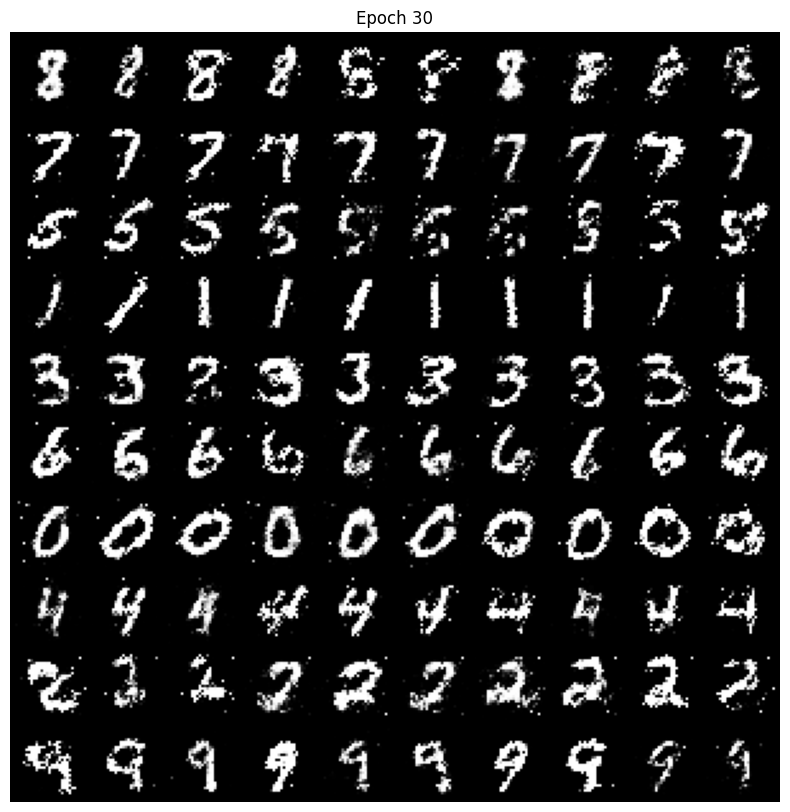

[Epoch 31/50] [Batch 0/938] [D loss: 0.6896] [G loss: 0.6930] [C loss: 1.5019]
[Epoch 31/50] [Batch 100/938] [D loss: 0.6884] [G loss: 0.7010] [C loss: 1.4618]
[Epoch 31/50] [Batch 200/938] [D loss: 0.6949] [G loss: 0.7087] [C loss: 1.4940]
[Epoch 31/50] [Batch 300/938] [D loss: 0.6896] [G loss: 0.6964] [C loss: 1.4659]
[Epoch 31/50] [Batch 400/938] [D loss: 0.6932] [G loss: 0.6914] [C loss: 1.5236]
[Epoch 31/50] [Batch 500/938] [D loss: 0.6899] [G loss: 0.6851] [C loss: 1.5335]
[Epoch 31/50] [Batch 600/938] [D loss: 0.6911] [G loss: 0.7007] [C loss: 1.4619]
[Epoch 31/50] [Batch 700/938] [D loss: 0.6912] [G loss: 0.7059] [C loss: 1.4619]
[Epoch 31/50] [Batch 800/938] [D loss: 0.6924] [G loss: 0.6874] [C loss: 1.4657]
[Epoch 31/50] [Batch 900/938] [D loss: 0.6907] [G loss: 0.6995] [C loss: 1.4950]
[Epoch 32/50] [Batch 0/938] [D loss: 0.6939] [G loss: 0.6872] [C loss: 1.5080]
[Epoch 32/50] [Batch 100/938] [D loss: 0.6934] [G loss: 0.6865] [C loss: 1.4826]
[Epoch 32/50] [Batch 200/938] [D

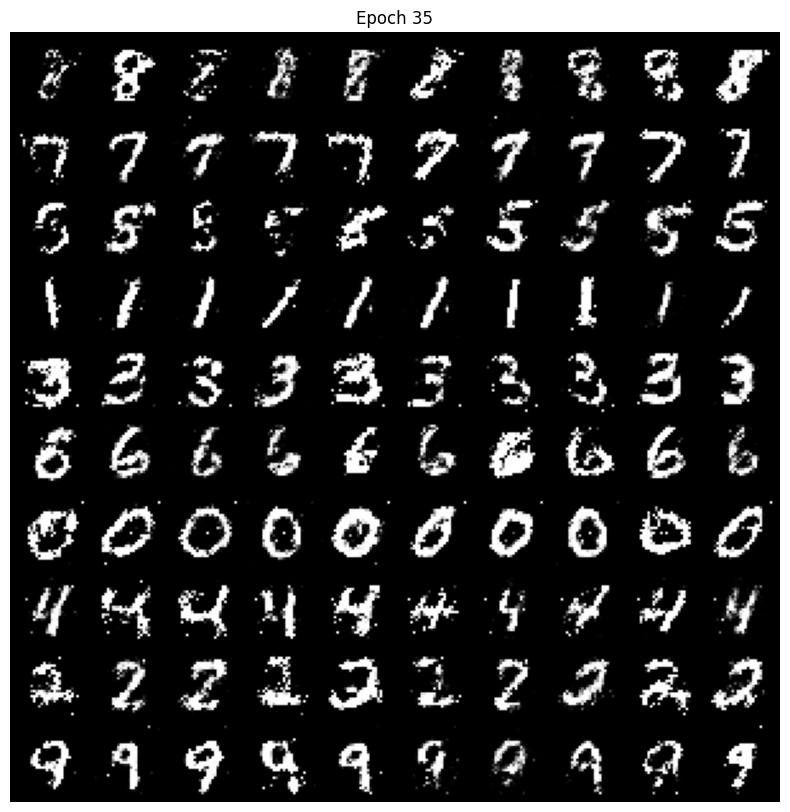

[Epoch 36/50] [Batch 0/938] [D loss: 0.6899] [G loss: 0.6922] [C loss: 1.4612]
[Epoch 36/50] [Batch 100/938] [D loss: 0.6905] [G loss: 0.6976] [C loss: 1.4613]
[Epoch 36/50] [Batch 200/938] [D loss: 0.6934] [G loss: 0.7021] [C loss: 1.4740]
[Epoch 36/50] [Batch 300/938] [D loss: 0.6894] [G loss: 0.7097] [C loss: 1.4612]
[Epoch 36/50] [Batch 400/938] [D loss: 0.6885] [G loss: 0.6861] [C loss: 1.4631]
[Epoch 36/50] [Batch 500/938] [D loss: 0.6961] [G loss: 0.6948] [C loss: 1.4768]
[Epoch 36/50] [Batch 600/938] [D loss: 0.6963] [G loss: 0.6948] [C loss: 1.4612]
[Epoch 36/50] [Batch 700/938] [D loss: 0.6935] [G loss: 0.6963] [C loss: 1.4931]
[Epoch 36/50] [Batch 800/938] [D loss: 0.6932] [G loss: 0.7117] [C loss: 1.4801]
[Epoch 36/50] [Batch 900/938] [D loss: 0.6952] [G loss: 0.6987] [C loss: 1.4629]
[Epoch 37/50] [Batch 0/938] [D loss: 0.6921] [G loss: 0.6854] [C loss: 1.4613]
[Epoch 37/50] [Batch 100/938] [D loss: 0.6895] [G loss: 0.7047] [C loss: 1.4761]
[Epoch 37/50] [Batch 200/938] [D

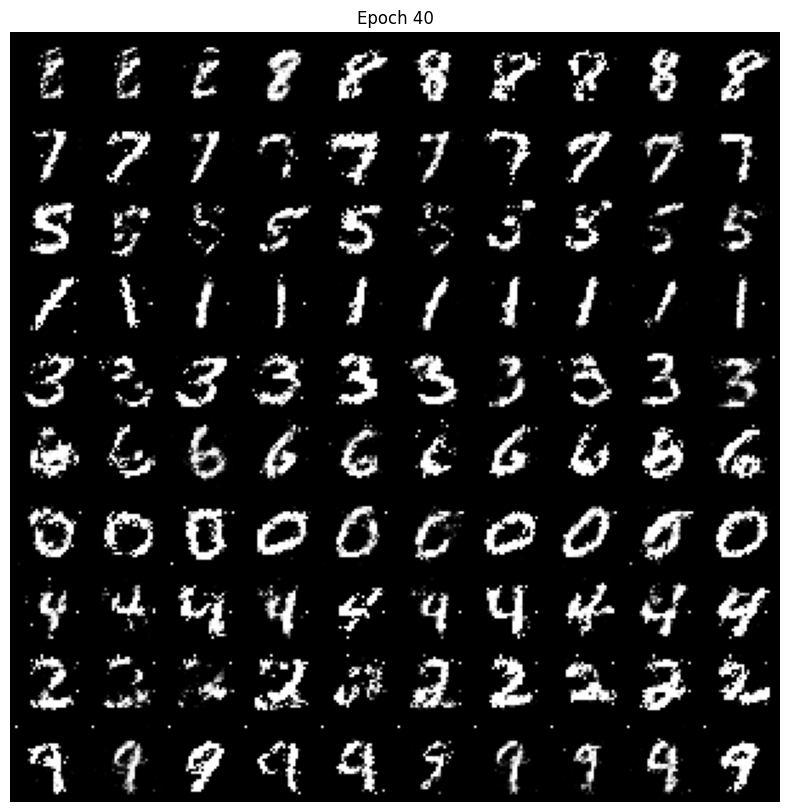

[Epoch 41/50] [Batch 0/938] [D loss: 0.6885] [G loss: 0.7068] [C loss: 1.4619]
[Epoch 41/50] [Batch 100/938] [D loss: 0.6911] [G loss: 0.6957] [C loss: 1.4769]
[Epoch 41/50] [Batch 200/938] [D loss: 0.6884] [G loss: 0.7144] [C loss: 1.5013]
[Epoch 41/50] [Batch 300/938] [D loss: 0.7019] [G loss: 0.6981] [C loss: 1.4926]
[Epoch 41/50] [Batch 400/938] [D loss: 0.6945] [G loss: 0.6885] [C loss: 1.4882]
[Epoch 41/50] [Batch 500/938] [D loss: 0.6940] [G loss: 0.6997] [C loss: 1.4766]
[Epoch 41/50] [Batch 600/938] [D loss: 0.6896] [G loss: 0.6909] [C loss: 1.4699]
[Epoch 41/50] [Batch 700/938] [D loss: 0.6893] [G loss: 0.6920] [C loss: 1.4863]
[Epoch 41/50] [Batch 800/938] [D loss: 0.6929] [G loss: 0.7083] [C loss: 1.5058]
[Epoch 41/50] [Batch 900/938] [D loss: 0.6951] [G loss: 0.7137] [C loss: 1.4624]
[Epoch 42/50] [Batch 0/938] [D loss: 0.6900] [G loss: 0.7028] [C loss: 1.4612]
[Epoch 42/50] [Batch 100/938] [D loss: 0.6937] [G loss: 0.6827] [C loss: 1.4750]
[Epoch 42/50] [Batch 200/938] [D

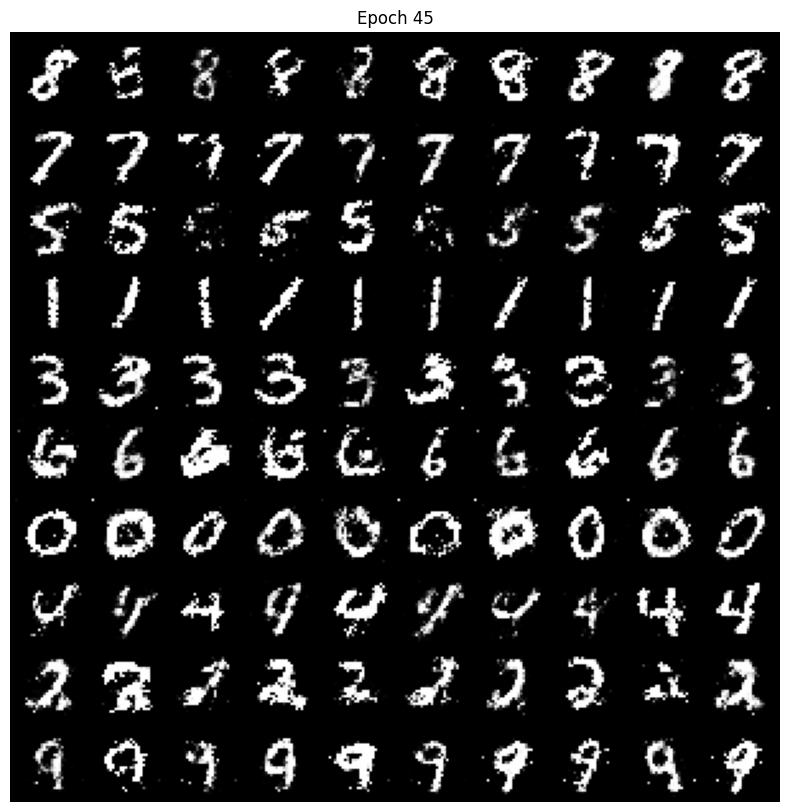

[Epoch 46/50] [Batch 0/938] [D loss: 0.6976] [G loss: 0.6877] [C loss: 1.4933]
[Epoch 46/50] [Batch 100/938] [D loss: 0.6948] [G loss: 0.7040] [C loss: 1.4766]
[Epoch 46/50] [Batch 200/938] [D loss: 0.6913] [G loss: 0.6899] [C loss: 1.4624]
[Epoch 46/50] [Batch 300/938] [D loss: 0.6889] [G loss: 0.6958] [C loss: 1.4925]
[Epoch 46/50] [Batch 400/938] [D loss: 0.6918] [G loss: 0.6898] [C loss: 1.4754]
[Epoch 46/50] [Batch 500/938] [D loss: 0.6942] [G loss: 0.6988] [C loss: 1.4768]
[Epoch 46/50] [Batch 600/938] [D loss: 0.6886] [G loss: 0.6896] [C loss: 1.4619]
[Epoch 46/50] [Batch 700/938] [D loss: 0.6970] [G loss: 0.7021] [C loss: 1.4685]
[Epoch 46/50] [Batch 800/938] [D loss: 0.6948] [G loss: 0.6923] [C loss: 1.4853]
[Epoch 46/50] [Batch 900/938] [D loss: 0.6928] [G loss: 0.7066] [C loss: 1.4841]
[Epoch 47/50] [Batch 0/938] [D loss: 0.6910] [G loss: 0.6954] [C loss: 1.4612]
[Epoch 47/50] [Batch 100/938] [D loss: 0.6873] [G loss: 0.7028] [C loss: 1.4830]
[Epoch 47/50] [Batch 200/938] [D

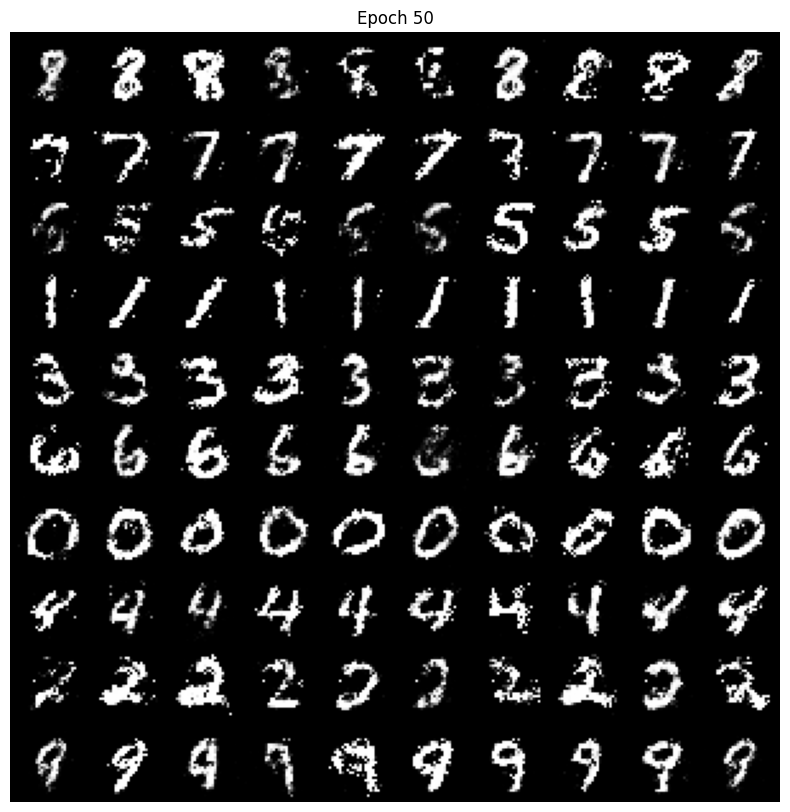

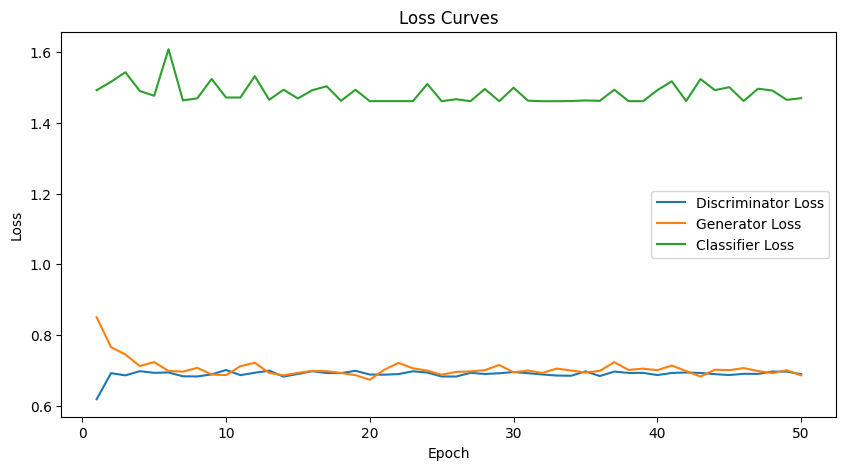

In [10]:
# Start training
train(hyperparams)
